In [17]:
import os
import sys
import numpy as np
import pandas as pd
import csv
import open3d as o3d
from matplotlib import pyplot as plt
import scipy
import scipy.io
import skimage
import utils
from utils import computeRMSE, computeRMSD, computeASSD, computeHD
import projection_utils as proj
import functools
import ray
import psutil
from projection_utils import PHOTO
from emopt5views_parallel_rotvec_grad import EMOpt5Views

In [6]:
# SSM_DIR = r"./data/cpdAlignedData/eigValVec/" 
# CPD_ALIGNED_DIR = r"./data/cpdAlignedData/" 
# PARAM_DIR = r"./data/params/" 
# SRC_DIR = r"./dataWithPhoto/cpdAlignedData/"
# SRC_PARAM_DIR = r"./dataWithPhoto/params/" 

SSM_DIR = r"./data/cpdGpAlignedData/eigValVec/" 
CPD_ALIGNED_DIR = r"./data/cpdGpAlignedData/" 
PARAM_DIR = r"./data/cpdGpParams/" 
SRC_DIR = r"./dataWithPhoto/cpdGpAlignedData/"
SRC_PARAM_DIR = r"./dataWithPhoto/cpdGpParams/"

NUM_PC = 10 # 3
NUM_POINT = 1500
PG_SHAPE = (NUM_POINT, 3)
UPPER_INDICES = [11,12,13,14,15,16,17,21,22,23,24,25,26,27] #不考虑智齿18,28
LOWER_INDICES = [31,32,33,34,35,36,37,41,42,43,44,45,46,47] #不考虑智齿38,48

NAME_IDX_MAP_CSV = r"./dataWithPhoto/nameIndexMapping.csv"

PG_NPY = os.path.join(SRC_PARAM_DIR, "Y_pg.npy")
MASK_NPY = os.path.join(SRC_PARAM_DIR, "X_mask.npy")

MATLAB_PATH = r"./matlab_script"
FOLD_IDX = 1 # change this index each fold
VERSION = "v21" # version of teeth silouette extraction model
EDGE_MASK_PATH = r"./dataWithPhoto/learning/fold{}/test/pred-{}/".format(FOLD_IDX,VERSION)
STAGE0_MAT_DIR = os.path.join(MATLAB_PATH, "stage0-mat")
# DEMO_H5_DIR = r"./dataWithPhoto/demo/"
# DEMO_MESH_DIR = r"./dataWithPhoto/demoMesh/"
NAME_IDX_CSV = pd.read_csv(NAME_IDX_MAP_CSV)

# LOG_DIR = r"./dataWithPhoto/log/"
# print = functools.partial(print, flush=True)

# # Run it only once
# utils.saveEigValVec(CPD_ALIGNED_DIR, NumPC2Save=100)

# # Run it only once
# src_invRegistrationParamDF = proj.loadInvRegistrationParams(loadDir=SRC_PARAM_DIR) # 加载待优化点云配准过程中的参数
# Mu, SqrtEigVals, Sigma = proj.loadMuEigValSigma(SSM_DIR, numPC=NUM_PC)
# Y_pg, X_mask, Y_scale, Y_rxyz, Y_txyz, Y_fVec = proj.loadDataSet(src_invRegistrationParamDF, Mu, Sigma, pgShape=PG_SHAPE, srcRootDir=SRC_DIR)
# np.save(PG_NPY, np.array(Y_pg))
# np.save(MASK_NPY, np.array(X_mask))



def meanShapeAlignmentEvaluation(with_scale=False):
    '''使用均值模型与待预测点云真实值配准，评估RMSE'''
    pgs = np.load(PG_NPY)
    masks = np.load(MASK_NPY)
    Mu, SqrtEigVals, Sigma = proj.loadMuEigValSigma(SSM_DIR, numPC=NUM_PC)
    Mu_U, Mu_L = np.split(Mu, 2, axis=0)
    print(Mu.shape)
    rmses = []
    for i in range(len(pgs)):
        pg = pgs[i]
        mask = np.squeeze(masks[i])
        mask_U, mask_L = np.split(mask, 2, axis=0)
        pg_U, pg_L = np.split(pg, 2, axis=0)
        TransMat_U = utils.computeTransMatByCorres(Mu_U[mask_U].reshape(-1,3), pg_U[mask_U].reshape(-1,3), with_scale)
        TransMat_L = utils.computeTransMatByCorres(Mu_L[mask_L].reshape(-1,3), pg_L[mask_L].reshape(-1,3), with_scale)
        T_Mu_U = np.matmul(Mu_U[mask_U], TransMat_U[:3,:3]) + TransMat_U[3,:3]
        T_Mu_L = np.matmul(Mu_L[mask_L], TransMat_L[:3,:3]) + TransMat_L[3,:3]
        rmse1 = computeRMSE(T_Mu_U, pg_U[mask_U])
        rmse2 = computeRMSE(T_Mu_L, pg_L[mask_L])
        rmses.append(rmse1)
        rmses.append(rmse2)
    print("with_scale: ", with_scale)
    print("Compare ground truth with aligned mean shape.")
    print("[RMSE] mm: {:.4f}".format(np.mean(rmses)))

In [7]:
TagID = 66

In [8]:
# phase 0: grid search parallelled by Ray
# phase 1: stage 0,1,2,3 optimization by scipy

print("TagID: ", TagID)

# 顺序相互对应
photo_types = ["upperPhoto","lowerPhoto","leftPhoto","rightPhoto","frontalPhoto"]
edgeMasks = proj.getEdgeMask(EDGE_MASK_PATH, NAME_IDX_CSV, TagID, photo_types, resized_width=800, binary=True, activation_thre=0.1)
# proj.visualizeEdgeMasks(edgeMasks, photo_types)

Mu, SqrtEigVals, Sigma = proj.loadMuEigValSigma(SSM_DIR, numPC=NUM_PC)

invRegistrationParamDF = proj.loadInvRegistrationParams(loadDir=PARAM_DIR) # 加载配准过程中的参数
invParamDF = proj.updateAbsTransVecs(invRegistrationParamDF, Mu) # 将牙列scale转化为每颗牙齿的位移，将每颗牙齿的transVecXYZs在局部坐标系下进行表达

invScaleMeans, invScaleVars, invRotVecXYZMeans, invRotVecXYZVars, invTransVecXYZMeans, invTransVecXYZVars = proj.getMeanAndVarianceOfInvRegistrationParams(invParamDF)
scaleStds = np.sqrt(invScaleVars)
transVecStds = np.sqrt(invTransVecXYZVars)
rotVecStds = np.sqrt(invRotVecXYZVars)
print("scaleStd: {:.4f}, transVecStd: {:.4f}, rotVecStd: {:.4f}".format(scaleStds.mean(), transVecStds.mean(), rotVecStds.mean()))

PoseCovMats = proj.GetPoseCovMats(invParamDF, toothIndices=UPPER_INDICES+LOWER_INDICES) # 每个位置的牙齿的6个变换参数的协方差矩阵,shape=(28,6,6)
ScaleCovMat = proj.GetScaleCovMat(invParamDF, toothIndices=UPPER_INDICES+LOWER_INDICES) # 牙齿scale的协方差矩阵,shape=(28,28)

Mask = proj.GetMaskByTagId(MASK_NPY, TagId=TagID)
# reference pointcloud
PG_Ref = proj.GetPGByTagId(PG_NPY, TagId=TagID)
X_Ref = PG_Ref[Mask]

TagID:  66
['./dataWithPhoto/learning/fold1/test/pred-v21/邢海悦_219477_上牙列.png', './dataWithPhoto/learning/fold1/test/pred-v21/邢海悦_219477_下牙列.png', './dataWithPhoto/learning/fold1/test/pred-v21/邢海悦_219477_左侧咬合.png', './dataWithPhoto/learning/fold1/test/pred-v21/邢海悦_219477_右侧咬合.png', './dataWithPhoto/learning/fold1/test/pred-v21/邢海悦_219477_正位像.png']
scaleStd: 0.0665, transVecStd: 1.1844, rotVecStd: 0.1391


In [10]:
# Optimization

print("-"*100)
print("Start optimization.")
# 初始化
photoTypes = [PHOTO.UPPER, PHOTO.LOWER, PHOTO.LEFT, PHOTO.RIGHT, PHOTO.FRONTAL]
VISIBLE_MASKS = [proj.MASK_UPPER, proj.MASK_LOWER, proj.MASK_LEFT, proj.MASK_RIGHT, proj.MASK_FRONTAL]
emopt = EMOpt5Views(edgeMasks, photoTypes, VISIBLE_MASKS, Mask, Mu, SqrtEigVals, Sigma, PoseCovMats, ScaleCovMat, transVecStds.mean(), rotVecStds.mean())

stage0initMatFile = os.path.join(STAGE0_MAT_DIR, "E-step-result-stage0-init-{}.mat".format(TagID))
stage0finalMatFile = os.path.join(STAGE0_MAT_DIR, "TEMP-E-step-result-stage0-final.mat")
# stage2initMatFile = os.path.join(STAGE0_MAT_DIR, "E-step-result-stage2-init-{}.mat".format(TagID))


print("num of observed edge points: ", emopt.M)
print("ex_rxyz: ", emopt.ex_rxyz)
print("ex_txyz: ", emopt.ex_txyz)
print("rela_rxyz: ", emopt.rela_rxyz)
print("rela_txyz: ", emopt.rela_txyz)
print("focal length: ", emopt.focLth)
print("d_pixel: ", emopt.dpix)
print("u0: {}, v0: {}".format(emopt.u0, emopt.v0))
print("[RMSE] Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(emopt.X_trans, X_Ref)))
print("[ASSD] average symmetric surface distance (mm): {:.4f}".format(computeASSD(emopt.X_trans, X_Ref)))
print("[HD] Hausdorff distance (mm): {:.4f}".format(computeHD(emopt.X_trans, X_Ref)))

----------------------------------------------------------------------------------------------------
Start optimization.
num of observed edge points:  [10017, 9751, 8405, 8407, 10227]
ex_rxyz:  [[ 2.19911486  0.          0.        ]
 [-2.19911486  0.          0.        ]
 [ 2.8         0.         -1.42      ]
 [ 2.8         0.          1.42      ]
 [ 3.14159265  0.          0.        ]]
ex_txyz:  [[  0.   0.  70.]
 [  0.   0.  70.]
 [ -5.   0. 120.]
 [  5.   0. 120.]
 [  0.  -2. 120.]]
rela_rxyz:  [0. 0. 0.]
rela_txyz:  [ 0. -5.  0.]
focal length:  [100. 100. 100. 100. 100.]
d_pixel:  [0.1  0.1  0.06 0.06 0.06]
u0: [400. 400. 400. 400. 400.], v0: [300. 300. 300. 300. 300.]
[RMSE] Root Mean Squared Surface Distance(mm): 1.5659
[ASSD] average symmetric surface distance (mm): 0.7420
[HD] Hausdorff distance (mm): 1.9166


In [9]:
# phase 0: grid search parallelled by Ray


print("-"*100)
print("Start Grid Search.")

# parallel function supported by Ray
emopt.searchDefaultRelativePoseParams()
emopt.gridSearchExtrinsicParams()
emopt.gridSearchRelativePoseParams()

print("ex_rxyz: ", emopt.ex_rxyz)
print("ex_txyz: ", emopt.ex_txyz)
print("rela_rxyz: ", emopt.rela_rxyz)
print("rela_txyz: ", emopt.rela_txyz)
print("focal length: ", emopt.focLth)
print("d_pixel: ", emopt.dpix)
print("u0: {}, v0: {}".format(emopt.u0, emopt.v0))
emopt.expectation_step_5Views(verbose=True)

# emopt.save_expectation_step_result_with_XRef(stage0initMatFile, X_Ref)

In [11]:
# phase 1: stage 0 & 1 optimization by Matlab


maxiter = 20
stageIter = [10,5,10]

print("-"*100)
print("Start Stage 0.")
# Continue from checkpoint "E-step-result-stage0-init-{}.mat"
stage = 0
emopt.load_expectation_step_result(stage0initMatFile, stage)
emopt.expectation_step_5Views(verbose=True)
print("Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(emopt.X_trans, X_Ref)))        
E_loss = []
for it in range(stageIter[0]):
    emopt.maximization_step_5Views(stage, step=-1, maxiter=maxiter, verbose=False)

    print("M-step loss: {:.4f}".format(emopt.loss_maximization_step))
    emopt.expectation_step_5Views(verbose=True)
    e_loss = np.sum(emopt.weightViews * emopt.loss_expectation_step)
    print("Sum of expectation step loss: {:.4f}".format(e_loss))
    print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
    if len(E_loss)>=2 and e_loss>=np.mean(E_loss[-2:]):
        print("Early stop with last 3 e-step loss {:.4f}, {:.4f}, {:.4f}".format(E_loss[-2],E_loss[-1],e_loss))
        E_loss.append(e_loss)
        break
    else:
        E_loss.append(e_loss)
        
# emopt.save_expectation_step_result_with_XRef(stage0finalMatFile, X_Ref)

----------------------------------------------------------------------------------------------------
Start Stage 0.
PHOTO.UPPER - unique pred points: 1119 - E-step loss: 14.83
PHOTO.LOWER - unique pred points: 1118 - E-step loss: 17.29
PHOTO.LEFT - unique pred points: 802 - E-step loss: 15.43
PHOTO.RIGHT - unique pred points: 807 - E-step loss: 22.23
PHOTO.FRONTAL - unique pred points: 1092 - E-step loss: 33.86
Root Mean Squared Surface Distance(mm): 1.5659
M-step loss: 878.8257
PHOTO.UPPER - unique pred points: 1120 - E-step loss: 14.84
PHOTO.LOWER - unique pred points: 1115 - E-step loss: 17.28
PHOTO.LEFT - unique pred points: 804 - E-step loss: 15.40
PHOTO.RIGHT - unique pred points: 806 - E-step loss: 22.23
PHOTO.FRONTAL - unique pred points: 1093 - E-step loss: 33.86
Sum of expectation step loss: 103.6151
iteration: 0, real Root Mean Squared Surface Distance(mm): 1.5659
M-step loss: 878.4777
PHOTO.UPPER - unique pred points: 1120 - E-step loss: 14.84
PHOTO.LOWER - unique pred poin

In [12]:
skipStage1Flag = False
print("-"*100)
print("Start Stage 1.")

stage = 1
for it in range(stageIter[1]): 
    emopt.maximization_step_5Views(stage, step=-1, maxiter=maxiter, verbose=False)

    print("M-step loss: {:.4f}".format(emopt.loss_maximization_step))
    emopt.expectation_step_5Views(verbose=True)
    e_loss = np.sum(emopt.weightViews * emopt.loss_expectation_step)
    print("Sum of expectation step loss: {:.4f}".format(e_loss))
    print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
    if e_loss >= E_loss[-1]: # len(E_loss)>=2 and e_loss>=np.mean(E_loss[-2:]):
        # 判断条件1：是否跳过stage1
        if it == 0:
            skipStage1Flag = True # first optimization with rowScaleXZ gets worse result compared with optimziaiton without rowScaleXZ
        print("Early stop with last 3 e-step loss {:.4f}, {:.4f}, {:.4f}".format(E_loss[-2],E_loss[-1],e_loss))
        break
    else:
        E_loss.append(e_loss)


print("emopt.rowScaleXZ: ", emopt.rowScaleXZ)
print("approx tooth scale: ", np.prod(emopt.rowScaleXZ)**(1/3))

----------------------------------------------------------------------------------------------------
Start Stage 1.


D:\anaconda3\envs\ssa\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


M-step loss: 833.6293
PHOTO.UPPER - unique pred points: 1145 - E-step loss: 13.69
PHOTO.LOWER - unique pred points: 1117 - E-step loss: 15.52
PHOTO.LEFT - unique pred points: 785 - E-step loss: 16.10
PHOTO.RIGHT - unique pred points: 793 - E-step loss: 22.57
PHOTO.FRONTAL - unique pred points: 1103 - E-step loss: 31.40
Sum of expectation step loss: 99.2953
iteration: 0, real Root Mean Squared Surface Distance(mm): 1.4962
M-step loss: 808.9425
PHOTO.UPPER - unique pred points: 1143 - E-step loss: 12.56
PHOTO.LOWER - unique pred points: 1113 - E-step loss: 13.86
PHOTO.LEFT - unique pred points: 810 - E-step loss: 15.74
PHOTO.RIGHT - unique pred points: 816 - E-step loss: 22.14
PHOTO.FRONTAL - unique pred points: 1059 - E-step loss: 30.16
Sum of expectation step loss: 94.4567
iteration: 1, real Root Mean Squared Surface Distance(mm): 1.5432
M-step loss: 774.6144
PHOTO.UPPER - unique pred points: 1143 - E-step loss: 12.28
PHOTO.LOWER - unique pred points: 1126 - E-step loss: 13.72
PHOTO.LE

In [13]:
# 判断是否跳过stage1
if skipStage1Flag == True:
    print("Skip Stage 1; Reverse to Stage 0 final result.")
    emopt.rowScaleXZ = np.ones((2,))
    emopt.load_expectation_step_result(stage0finalMatFile, stage=2)
    emopt.expectation_step_5Views(verbose=True)
else:
    print("Accept Stage 1.")
    emopt.anistropicRowScale2ScalesAndTransVecs()      
print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))

# 保存用于phase2的初始变量
# emopt.save_expectation_step_result_with_XRef(stage2initMatFile, X_Ref)

Accept Stage 1.
iteration: 2, real Root Mean Squared Surface Distance(mm): 1.5535


In [14]:
# Stage = 2
print("-"*100)
print("Start Stage 2.")
stage = 2

# # load previous data
# emopt.load_expectation_step_result(stage2initMatFile, stage)
emopt.expectation_step_5Views(verbose=True)


E_loss = []
for it in range(stageIter[2]):
    # emopt.maximization_step_5Views(stage=2, step=4, maxiter=maxiter, verbose=False)
    emopt.maximization_step_5Views(stage, step=2, maxiter=maxiter, verbose=False)
    emopt.maximization_step_5Views(stage, step=3, maxiter=maxiter, verbose=False)
    emopt.maximization_step_5Views(stage=3, step=-1, maxiter=maxiter, verbose=False)
    emopt.maximization_step_5Views(stage, step=1, maxiter=maxiter, verbose=False)
    print("M-step loss: {:.4f}".format(emopt.loss_maximization_step))
    emopt.expectation_step_5Views(verbose=True)
    e_loss = np.sum(emopt.weightViews * emopt.loss_expectation_step)
    print("Sum of expectation step loss: {:.4f}".format(e_loss))
    print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
    if len(E_loss)>=2 and (e_loss>=np.mean(E_loss[-2:])):
        print("Early stop with last 3 e-step loss {:.4f}, {:.4f}, {:.4f}".format(E_loss[-2],E_loss[-1],e_loss))
        break
    else:
        E_loss.append(e_loss)


print("[RMSE] Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(X_Ref, emopt.X_trans)))
print("[ASSD] average symmetric surface distance (mm): {:.4f}".format(computeASSD(X_Ref, emopt.X_trans)))
print("[HD] Hausdorff distance (mm): {:.4f}".format(computeHD(X_Ref, emopt.X_trans)))

----------------------------------------------------------------------------------------------------
Start Stage 2.
PHOTO.UPPER - unique pred points: 1157 - E-step loss: 12.63
PHOTO.LOWER - unique pred points: 1118 - E-step loss: 14.26
PHOTO.LEFT - unique pred points: 822 - E-step loss: 15.27
PHOTO.RIGHT - unique pred points: 812 - E-step loss: 24.28
PHOTO.FRONTAL - unique pred points: 1072 - E-step loss: 29.75
M-step loss: 514.8497
PHOTO.UPPER - unique pred points: 1209 - E-step loss: 6.77
PHOTO.LOWER - unique pred points: 1190 - E-step loss: 9.49
PHOTO.LEFT - unique pred points: 892 - E-step loss: 8.05
PHOTO.RIGHT - unique pred points: 906 - E-step loss: 10.37
PHOTO.FRONTAL - unique pred points: 1104 - E-step loss: 16.11
Sum of expectation step loss: 50.8001
iteration: 0, real Root Mean Squared Surface Distance(mm): 1.4181
M-step loss: 356.1226
PHOTO.UPPER - unique pred points: 1233 - E-step loss: 5.11
PHOTO.LOWER - unique pred points: 1232 - E-step loss: 7.44
PHOTO.LEFT - unique pre

In [ ]:
print("-"*100)
print("Evaluation.")

invRotVecXYZVars = invRotVecXYZVars.reshape(-1,3)
invTransVecXYZVars = invTransVecXYZVars.reshape(-1,3)
print("standard transVecXYZs:")
print((emopt.transVecXYZs - emopt.meanTransVecXYZs) / np.sqrt(invTransVecXYZVars[Mask]))
print("standard rotVecXYZs:")
print((emopt.rotVecXYZs - emopt.meanRotVecXYZs) / np.sqrt(invRotVecXYZVars[Mask]))
print("scales:")
print(emopt.scales)
print("feature vectors:")
print(emopt.featureVec)

# 不考虑第二磨牙
withoutSecondMolarMask = np.tile(np.array([1,1,1,1,1,1,0],dtype=np.bool_),(4,))
print("Without Second Molar, Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(emopt.X_trans[withoutSecondMolarMask[Mask]], X_Ref[withoutSecondMolarMask[Mask]])))

# # Save Demo Result

# demoH5File = os.path.join(DEMO_H5_DIR, "demo_TagID={}.h5".format(TagID))
# emopt.saveDemo2H5(demoH5File, TagID, X_Ref)

In [34]:
def showEdgeMaskPredictionWithGroundTruth(emopt, photoType, canvasShape=None, dilate=True):
    # red: prediction, white: ground truth
    ph = photoType.value
    if not bool(canvasShape):
        canvasShape = emopt.edgeMask[ph].shape
    canvas = np.zeros((*canvasShape,3), dtype=np.float64)
    h, w = emopt.edgeMask[ph].shape
    canvas[:h,:w,:] = emopt.edgeMask[ph][:,:,None] # white: ground truth

    edgePred = np.zeros(canvasShape, dtype=np.float64)
    pix_pred = emopt.P_pred[ph].astype(np.int32)
    edgePred[pix_pred[:,1], pix_pred[:,0]] = 1. # red: edge prediction
    if dilate == True:
        edgePred = skimage.morphology.binary_dilation(edgePred, skimage.morphology.disk(2)) # dilation edge prediction for visualization
    canvas[:,:,0] = np.max(np.stack([edgePred,canvas[:,:,0]]), axis=0)

    plt.figure(figsize = (10,10))
    plt.axis('off')
    plt.imshow(canvas)
    return canvas

def showEdgePrediction(emopt, photoType, canvasShape=None, dilate=True):
    # red: prediction, white: ground truth
    ph = photoType.value
    if not bool(canvasShape):
        canvasShape = emopt.edgeMask[ph].shape
    canvas = np.zeros((*canvasShape,3), dtype=np.float64)
    h, w = emopt.edgeMask[ph].shape
    # canvas[:h,:w,:] = emopt.edgeMask[ph][:,:,None] # white: ground truth

    edgePred = np.zeros(canvasShape, dtype=np.float64)
    pix_pred = emopt.P_pred[ph].astype(np.int32)
    edgePred[pix_pred[:,1], pix_pred[:,0]] = 1. # red: edge prediction
    if dilate == True:
        edgePred = skimage.morphology.binary_dilation(edgePred, skimage.morphology.disk(3)) # dilation edge prediction for visualization
    canvas[:,:,0] = edgePred

    plt.figure(figsize = (10,10))
    plt.axis('off')
    plt.imshow(canvas)
    return canvas

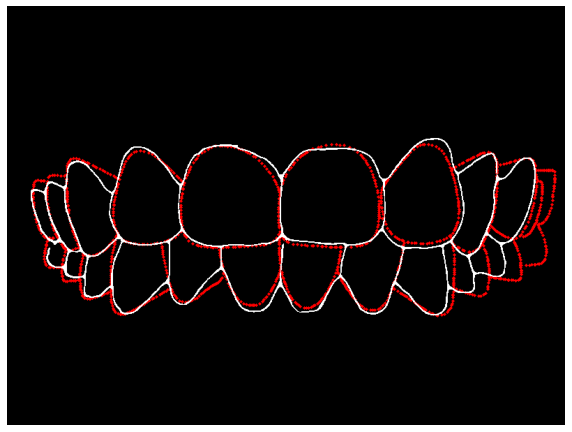

In [39]:
_ = showEdgeMaskPredictionWithGroundTruth(emopt, PHOTO.FRONTAL, canvasShape=None, dilate=True)

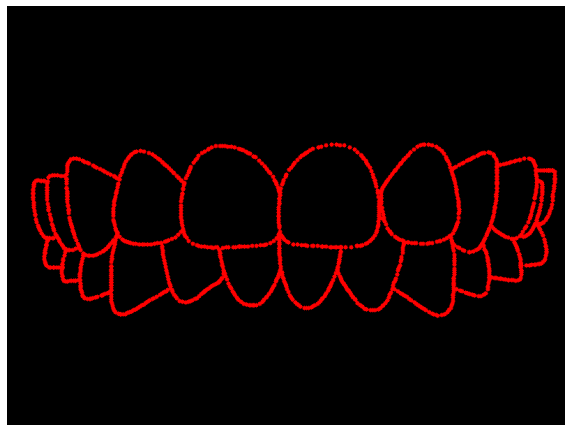

In [40]:
_ = showEdgePrediction(emopt, PHOTO.FRONTAL, canvasShape=None, dilate=True)